In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import os
import dataclasses
import sys
import ast

# Add the project root directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import custom modules
from Model.modules_lstm import LSTMEncoder
from Model.modules_dense_nn import DenseNN, PersonalizedScalarNN
from Model.dbn import DBNModel, DBNConfig
from Model.data import WorkoutDataset, WorkoutDatasetConfig, make_dataloaders
from Model.trainer import Trainer

In [2]:
import dataclasses
import pandas as pd

df = pd.read_feather("../output/endomondo.feather")
df_tmp = df

In [3]:
data_config_train = WorkoutDatasetConfig(
    subject_id_column = "userId",
    workout_id_column = "id",
    time_since_start_column ='time_grid',
    time_of_start_column = 'start_dt',
    heart_rate_column = 'heart_rate',
    heart_rate_normalized_column = 'heart_rate_normalized',
    activity_columns = ["speed_h", "speed_v"],
    weather_columns = [],
    history_max_length=512,   
)
data_config_test = dataclasses.replace(data_config_train, chunk_size=None, stride=None)

train_dataset = WorkoutDataset(df_tmp[df_tmp["in_train"]], data_config_train)
test_dataset = WorkoutDataset(df_tmp, data_config_test)

train_dataloader, test_dataloader = make_dataloaders(train_dataset, test_dataset, batch_size=128)

100%|██████████| 38323/38323 [00:02<00:00, 14063.61it/s]


In [4]:
from Model.dbn import DBNModel, DBNConfig
from Model.trainer import Trainer

# Define Model Configuration
dbn_config = DBNConfig(
    data_config=data_config_train,
    seq_length=64, 
    learning_rate=1e-3,
    seed=0,
    n_epochs=10,
    lstm_hidden_dim=128,
    lstm_layers=2,
    dbn_hidden_dim=64,
    personalization="none",
    dim_personalization=8,
    subject_embedding_dim=8,
    encoder_embedding_dim=8,
    dropout=0.5,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Instantiate the Model
model = DBNModel(
    config=dbn_config,
    workouts_info=df_tmp[["userId", "id"]]
)
model

DBNModel(
  (embedding_store): EmbeddingStore(
    (subject_embeddings): Embedding(558, 8, max_norm=5.0)
    (encoder): LSTMEncoder(
      (lstm): LSTM(5, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (fc): Linear(in_features=256, out_features=8, bias=True)
      (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lstm_encoder): LSTMEncoder(
    (lstm): LSTM(5, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=256, out_features=8, bias=True)
    (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adafs_soft): AdaFSSoft(
    (controller): ControllerMLP(
      (mlp): MultiLayerPerceptron(
        (mlps): ModuleList(
          (0): Sequential(
            (0): Linear(in_features=1216, out_features=1216, bias=True)
      

In [5]:
from Model.trainer import Trainer

trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    learning_rate=dbn_config.learning_rate,
    n_epochs=dbn_config.n_epochs,
    device=dbn_config.device
)

trainer.train()

  0%|          | 0/2043 [00:00<?, ?it/s]d:\Final_code\Model\trainer.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activity = torch.tensor(batch["activity"]).float().to(self.device)
d:\Final_code\Model\trainer.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(batch["time"]).float().to(self.device)
d:\Final_code\Model\trainer.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  history = torch.tensor(batch["history"]).float().to(self.device) if batch["history"] is not None else None
d:\Final_code\Model\trainer

Validation loss decreased (11.774530 --> 11.774530).  Saving model ...
Epoch 0 took 226.6 seconds
Train mean l1: 10.677 bpm (= 7.103 %)
Test mean l1: 11.775 bpm (= 8.189 %)


100%|██████████| 300/300 [00:11<00:00, 25.33it/s]


Validation loss decreased (10.211634 --> 10.211634).  Saving model ...
Epoch 1 took 225.0 seconds
Train mean l1: 8.312 bpm (= 5.530 %)
Test mean l1: 10.212 bpm (= 7.102 %)


100%|██████████| 300/300 [00:11<00:00, 25.50it/s]


Epoch 2 took 224.9 seconds
Train mean l1: 8.296 bpm (= 5.519 %)
Test mean l1: 10.269 bpm (= 7.142 %)


100%|██████████| 300/300 [00:11<00:00, 25.64it/s]


Validation loss decreased (9.229153 --> 9.229153).  Saving model ...
Epoch 3 took 224.8 seconds
Train mean l1: 7.559 bpm (= 5.029 %)
Test mean l1: 9.229 bpm (= 6.418 %)


100%|██████████| 300/300 [00:11<00:00, 25.47it/s]


Validation loss decreased (9.127804 --> 9.127804).  Saving model ...
Epoch 4 took 225.1 seconds
Train mean l1: 7.395 bpm (= 4.920 %)
Test mean l1: 9.128 bpm (= 6.348 %)


100%|██████████| 300/300 [00:11<00:00, 25.39it/s]


Validation loss decreased (8.963729 --> 8.963729).  Saving model ...
Epoch 5 took 224.8 seconds
Train mean l1: 7.292 bpm (= 4.851 %)
Test mean l1: 8.964 bpm (= 6.234 %)


100%|██████████| 300/300 [00:11<00:00, 25.51it/s]


Validation loss decreased (8.850118 --> 8.850118).  Saving model ...
Epoch 6 took 224.8 seconds
Train mean l1: 7.158 bpm (= 4.762 %)
Test mean l1: 8.850 bpm (= 6.155 %)


100%|██████████| 300/300 [00:11<00:00, 25.74it/s]


Validation loss decreased (8.748276 --> 8.748276).  Saving model ...
Epoch 7 took 224.4 seconds
Train mean l1: 7.154 bpm (= 4.759 %)
Test mean l1: 8.748 bpm (= 6.084 %)


100%|██████████| 300/300 [00:11<00:00, 25.54it/s]


Epoch 8 took 225.1 seconds
Train mean l1: 7.114 bpm (= 4.733 %)
Test mean l1: 8.792 bpm (= 6.114 %)


100%|██████████| 300/300 [00:11<00:00, 25.52it/s]

Epoch 9 took 224.4 seconds
Train mean l1: 6.946 bpm (= 4.621 %)
Test mean l1: 8.751 bpm (= 6.086 %)


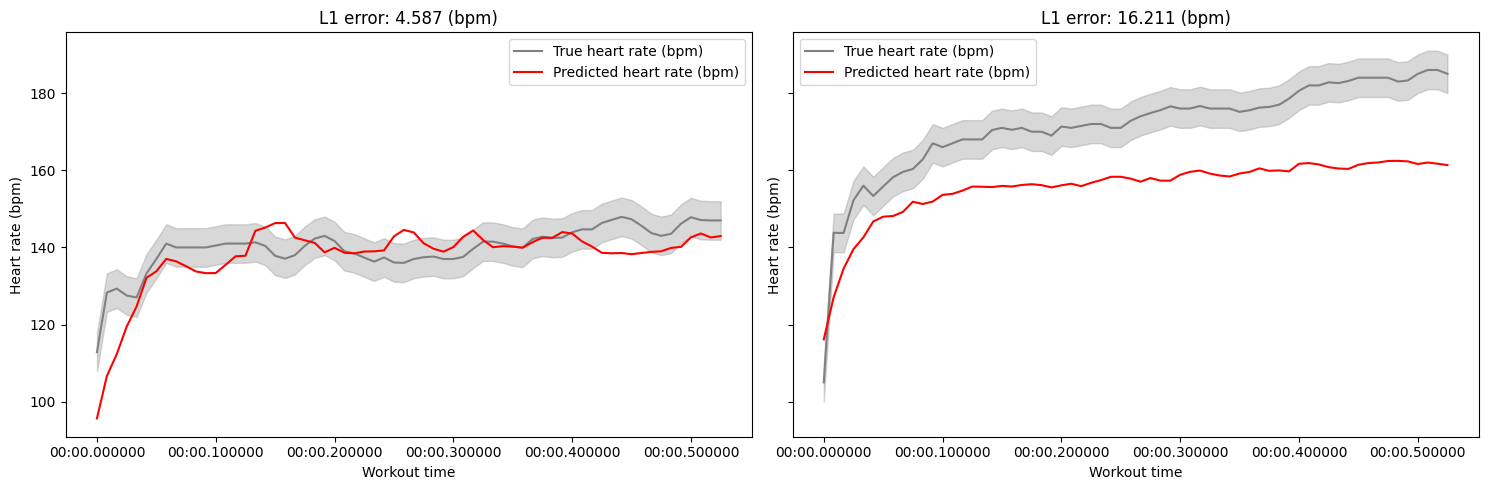

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_workouts_with_error_bands(model, workouts, error_std_dev=5):
    """
    Plots the true heart rate with error bands and the predicted heart rate for multiple workouts.
    """
    num_workouts = len(workouts)
    fig, axes = plt.subplots(1, num_workouts, figsize=(15, 5), sharex=True, sharey=True)

    for idx, workout in enumerate(workouts):
        time_in_datetime = pd.to_datetime(workout["time"], unit="s")
        true_heart_rate = workout["heart_rate"]
        predictions = model.forecast_single_workout(workout)
        predicted_heart_rate = predictions["heart_rate"]

        # Ensure that the lengths match
        min_length = min(len(true_heart_rate), len(predicted_heart_rate))
        true_heart_rate = true_heart_rate[:min_length]
        predicted_heart_rate = predicted_heart_rate[:min_length]
        time_in_datetime = time_in_datetime[:min_length]

        # Error bounds: standard deviation of ± 5 beats per minute
        error_bounds = np.full_like(true_heart_rate, error_std_dev)

        # Calculate L1 error (Mean Absolute Error)
        l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

        # Plotting
        ax = axes[idx]
        
        # Plot true heart rate with error bands
        ax.plot(time_in_datetime, true_heart_rate, color='gray', label='True heart rate (bpm)')
        ax.fill_between(time_in_datetime, true_heart_rate - error_bounds, true_heart_rate + error_bounds, color='gray', alpha=0.3)
        
        # Plot predicted heart rate
        ax.plot(time_in_datetime, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)')

        # Add labels and title
        ax.set_xlabel('Workout time')
        ax.set_ylabel('Heart rate (bpm)')
        ax.set_title(f'L1 error: {l1_error:.3f} (bpm)')
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot for two workouts from the test dataset
plot_multiple_workouts_with_error_bands(model, [test_dataset[10], test_dataset[17]])


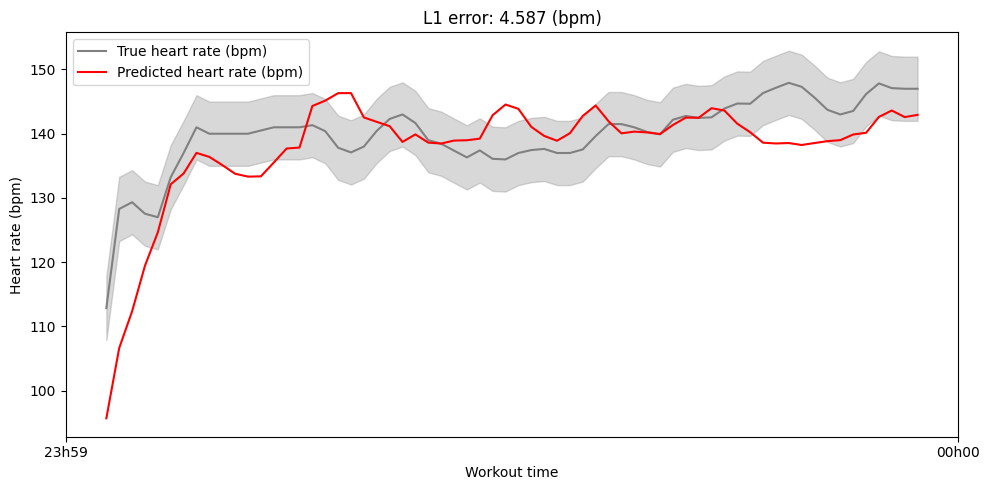

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_single_workout_with_error_bands(model, workout, error_std_dev=5):
    """
    Plots the true heart rate with error bands and the predicted heart rate for a single workout.
    """
    time_in_datetime = pd.to_datetime(workout["time"], unit="s")
    true_heart_rate = workout["heart_rate"]
    predictions = model.forecast_single_workout(workout)
    predicted_heart_rate = predictions["heart_rate"]

    # Ensure that the lengths match
    min_length = min(len(true_heart_rate), len(predicted_heart_rate))
    true_heart_rate = true_heart_rate[:min_length]
    predicted_heart_rate = predicted_heart_rate[:min_length]
    time_in_datetime = time_in_datetime[:min_length]

    # Error bounds: standard deviation of ± 5 beats per minute
    error_bounds = np.full_like(true_heart_rate, error_std_dev)

    # Calculate L1 error (Mean Absolute Error)
    l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot true heart rate with error bands
    ax.plot(time_in_datetime, true_heart_rate, color='gray', label='True heart rate (bpm)')
    ax.fill_between(time_in_datetime, true_heart_rate - error_bounds, true_heart_rate + error_bounds, color='gray', alpha=0.3)

    # Plot predicted heart rate
    ax.plot(time_in_datetime, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)')

    # Add labels and title
    ax.set_xlabel('Workout time')
    ax.set_ylabel('Heart rate (bpm)')
    ax.set_title(f'L1 error: {l1_error:.3f} (bpm)')
    ax.legend()

    # Format the x-axis to show workout time in "00h00", "00h05", "00h15", etc.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))  # Adjust the interval as needed

    plt.tight_layout()
    plt.show()

# Plot for the first workout from the test dataset
plot_single_workout_with_error_bands(model, test_dataset[10])



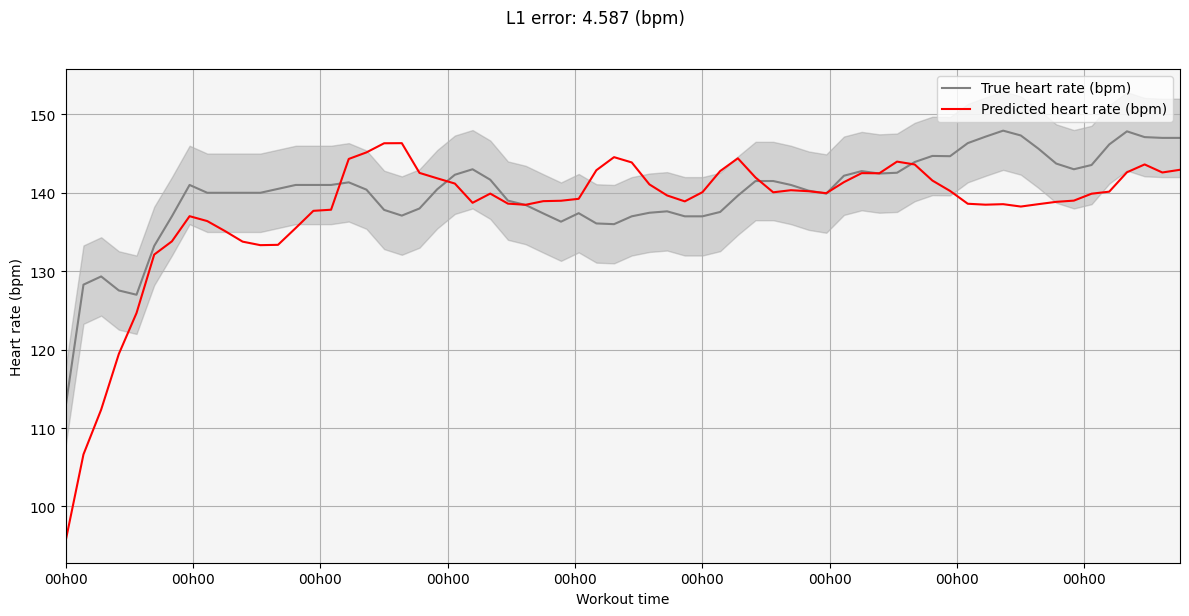

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_single_workout_with_error_bands(model, workout, error_std_dev=5):
    """
    Plots the true heart rate with error bands and the predicted heart rate for a single workout.
    """
    time_in_seconds = workout["time"]
    time_in_minutes = time_in_seconds / 60.0

    true_heart_rate = workout["heart_rate"]
    predictions = model.forecast_single_workout(workout)
    predicted_heart_rate = predictions["heart_rate"]

    # Ensure the lengths match
    if len(true_heart_rate) != len(predicted_heart_rate):
        min_len = min(len(true_heart_rate), len(predicted_heart_rate))
        true_heart_rate = true_heart_rate[:min_len]
        predicted_heart_rate = predicted_heart_rate[:min_len]
        time_in_minutes = time_in_minutes[:min_len]

    # Error bounds: standard deviation of ± 5 beats per minute
    error_bounds = np.full_like(true_heart_rate, error_std_dev)

    # Calculate L1 error (Mean Absolute Error)
    l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'L1 error: {l1_error:.3f} (bpm)', y=1.02)

    # Plot true heart rate with error bands
    ax.plot(time_in_minutes, true_heart_rate, color='gray', label='True heart rate (bpm)')
    ax.fill_between(time_in_minutes, true_heart_rate - error_bounds, true_heart_rate + error_bounds, color='gray', alpha=0.3)
    
    # Plot predicted heart rate
    ax.plot(time_in_minutes, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)')

    # Add labels and title
    ax.set_xlabel('Workout time')
    ax.set_ylabel('Heart rate (bpm)')
    ax.legend(loc="best")

    # Format the x-axis to show hours and minutes
    def format_func(value, tick_number):
        hours = int(value // 60)
        minutes = int(value % 60)
        return f'{hours:02d}h{minutes:02d}'

    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlim([time_in_minutes.min(), time_in_minutes.max()])

    # Add grid and style similar to Apple's plot
    ax.grid(True)
    ax.set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

# Plot for the first workout from the test dataset
plot_single_workout_with_error_bands(model, test_dataset[10])


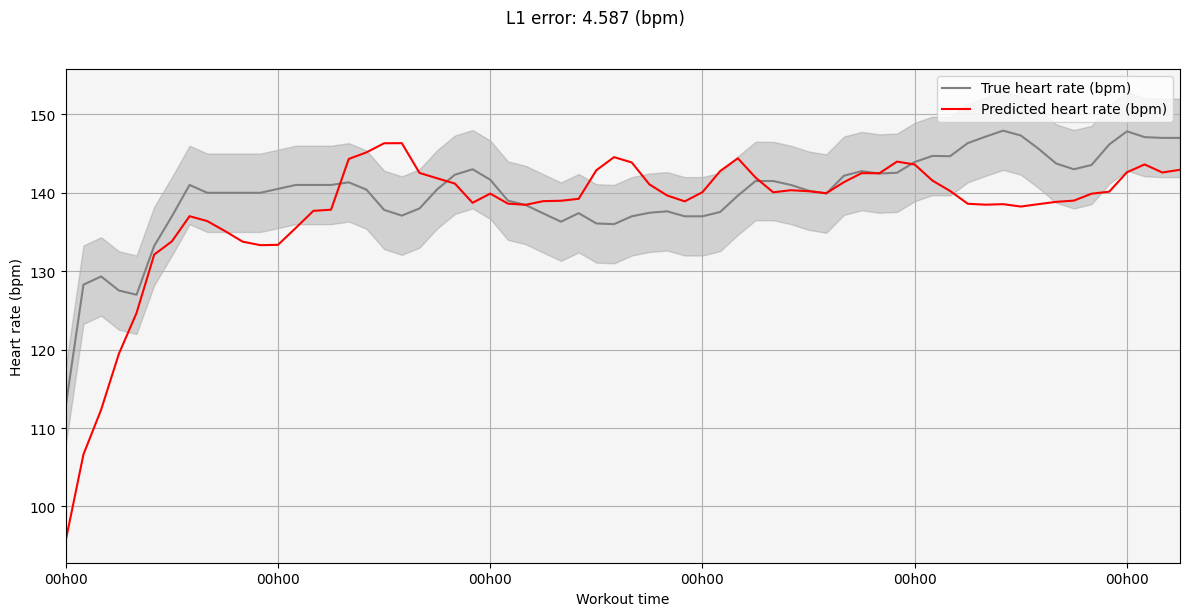

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

def format_time(x, pos=None):
    """ Custom formatter to convert seconds to hh:mm format. """
    minutes, seconds = divmod(x, 60)
    hours, minutes = divmod(minutes, 60)
    return f'{int(hours):02d}h{int(minutes):02d}'

def plot_single_workout_with_error_bands(model, workout, error_std_dev=5):
    """
    Plots the true heart rate with error bands and the predicted heart rate for a single workout.
    """
    time_in_seconds = workout["time"]
    true_heart_rate = workout["heart_rate"]
    predictions = model.forecast_single_workout(workout)
    predicted_heart_rate = predictions["heart_rate"]

    # Ensure the lengths match
    if len(true_heart_rate) != len(predicted_heart_rate):
        min_len = min(len(true_heart_rate), len(predicted_heart_rate))
        true_heart_rate = true_heart_rate[:min_len]
        predicted_heart_rate = predicted_heart_rate[:min_len]
        time_in_seconds = time_in_seconds[:min_len]

    # Error bounds: standard deviation of ± 5 beats per minute
    error_bounds = np.full_like(true_heart_rate, error_std_dev)

    # Calculate L1 error (Mean Absolute Error)
    l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'L1 error: {l1_error:.3f} (bpm)', y=1.02)

    # Plot true heart rate with error bands
    ax.plot(time_in_seconds, true_heart_rate, color='gray', label='True heart rate (bpm)')
    ax.fill_between(time_in_seconds, true_heart_rate - error_bounds, true_heart_rate + error_bounds, color='gray', alpha=0.3)
    
    # Plot predicted heart rate
    ax.plot(time_in_seconds, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)')

    # Add labels and title
    ax.set_xlabel('Workout time')
    ax.set_ylabel('Heart rate (bpm)')
    ax.legend(loc="best")
    
    # Format the x-axis
    ax.xaxis.set_major_formatter(FuncFormatter(format_time))
    ax.set_xlim([time_in_seconds.min(), time_in_seconds.max()])

    # Add grid and style similar to Apple's plot
    ax.grid(True)
    ax.set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

# Plot for the first workout from the test dataset
plot_single_workout_with_error_bands(model, test_dataset[10])



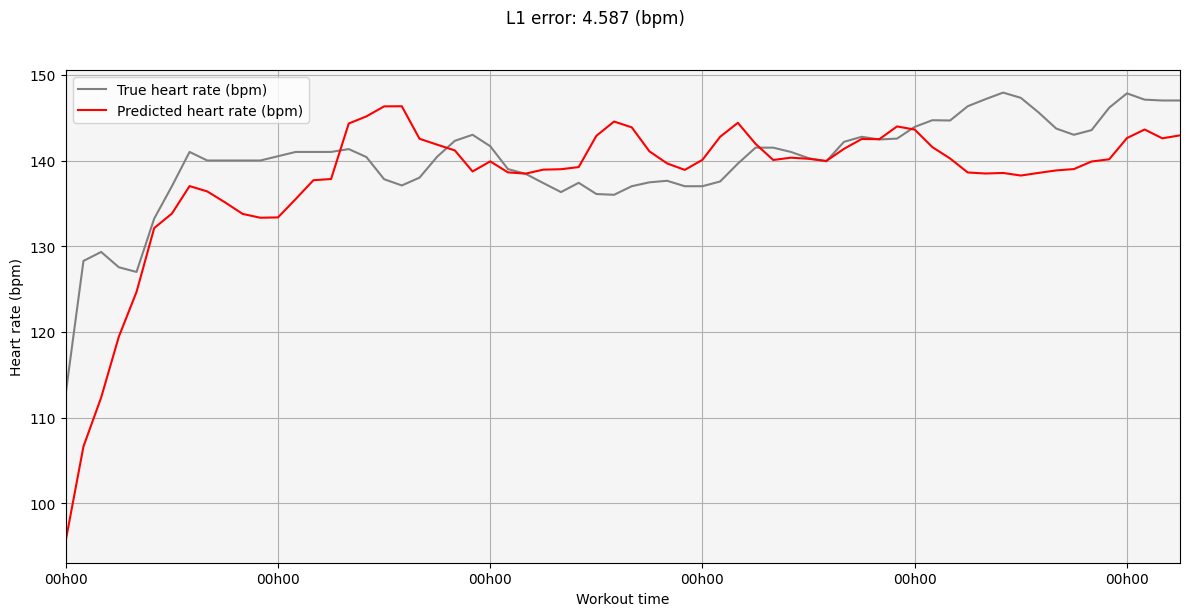

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

def plot_single_workout(model, workout):
    """
    Plots the true heart rate and the predicted heart rate for a single workout.
    """
    time_in_seconds = workout["time"]
    time_in_datetime = pd.to_datetime(time_in_seconds, unit="s") - pd.to_datetime(time_in_seconds[0], unit="s")
    time_in_datetime = time_in_datetime + pd.Timestamp('1970-01-01')

    true_heart_rate = workout["heart_rate"]
    predictions = model.forecast_single_workout(workout)
    predicted_heart_rate = predictions["heart_rate"]

    # Ensure the lengths match
    if len(true_heart_rate) != len(predicted_heart_rate):
        min_len = min(len(true_heart_rate), len(predicted_heart_rate))
        true_heart_rate = true_heart_rate[:min_len]
        predicted_heart_rate = predicted_heart_rate[:min_len]
        time_in_datetime = time_in_datetime[:min_len]

    # Calculate L1 error (Mean Absolute Error)
    l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'L1 error: {l1_error:.3f} (bpm)', y=1.02)

    # Plot true heart rate
    ax.plot(time_in_datetime, true_heart_rate, color='gray', label='True heart rate (bpm)')
    
    # Plot predicted heart rate
    ax.plot(time_in_datetime, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)')

    # Add labels and title
    ax.set_xlabel('Workout time')
    ax.set_ylabel('Heart rate (bpm)')
    ax.legend(loc="best")
    
    # Format the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Hh%M'))
    ax.set_xlim([time_in_datetime.min(), time_in_datetime.max()])
    
    # Add grid and style similar to Apple's plot
    ax.grid(True)
    ax.set_facecolor('#f5f5f5')
    
    plt.tight_layout()
    plt.show()

# Plot for the first workout from the test dataset
plot_single_workout(model, test_dataset[10])


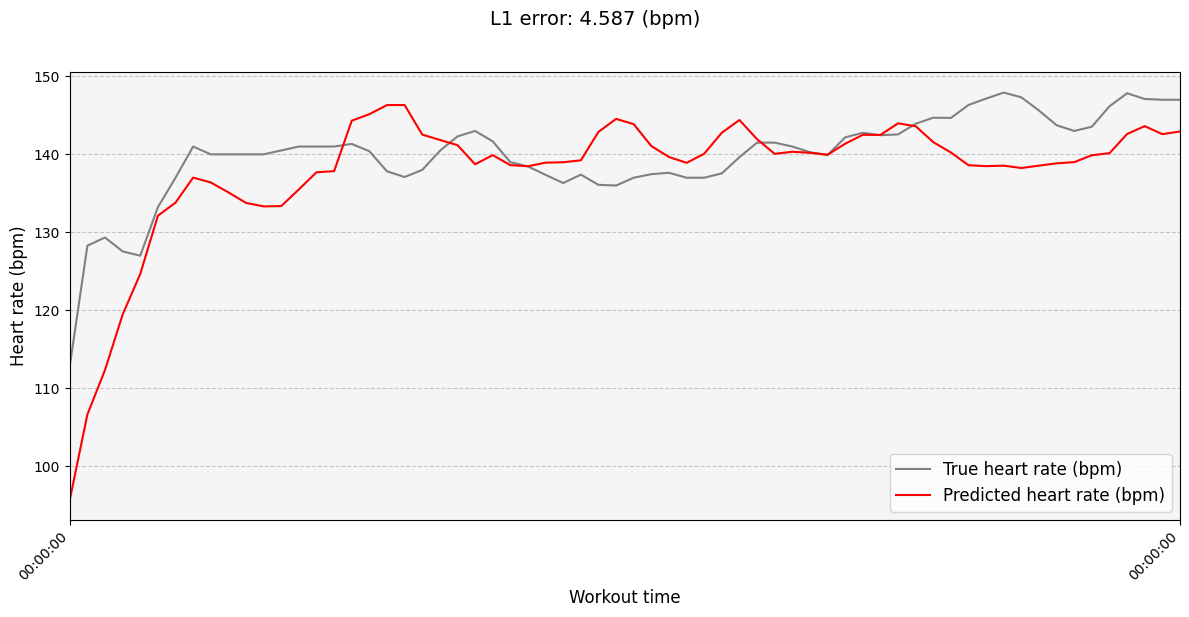

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

def plot_single_workout(model, workout):
    """
    Plots the true heart rate and the predicted heart rate for a single workout.
    """
    time_in_seconds = workout["time"]
    time_in_datetime = pd.to_datetime(time_in_seconds, unit="s") - pd.to_datetime(time_in_seconds[0], unit="s")
    time_in_datetime = time_in_datetime + pd.Timestamp('1970-01-01')

    true_heart_rate = workout["heart_rate"]
    predictions = model.forecast_single_workout(workout)
    predicted_heart_rate = predictions["heart_rate"]

    # Ensure the lengths match
    if len(true_heart_rate) != len(predicted_heart_rate):
        min_len = min(len(true_heart_rate), len(predicted_heart_rate))
        true_heart_rate = true_heart_rate[:min_len]
        predicted_heart_rate = predicted_heart_rate[:min_len]
        time_in_datetime = time_in_datetime[:min_len]

    # Calculate L1 error (Mean Absolute Error)
    l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'L1 error: {l1_error:.3f} (bpm)', y=1.02, fontsize=14)

    # Plot true heart rate
    ax.plot(time_in_datetime, true_heart_rate, color='gray', label='True heart rate (bpm)', linewidth=1.5)
    
    # Plot predicted heart rate
    ax.plot(time_in_datetime, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)', linewidth=1.5)

    # Add labels and title
    ax.set_xlabel('Workout time', fontsize=12)
    ax.set_ylabel('Heart rate (bpm)', fontsize=12)
    ax.legend(loc="best", fontsize=12)
    
    # Format the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim([time_in_datetime.min(), time_in_datetime.max()])
    
    # Add grid and style similar to Apple's plot
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_facecolor('#f5f5f5')
    
    # Adjust the x-axis ticks
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

# Plot for the first workout from the test dataset
plot_single_workout(model, test_dataset[10])


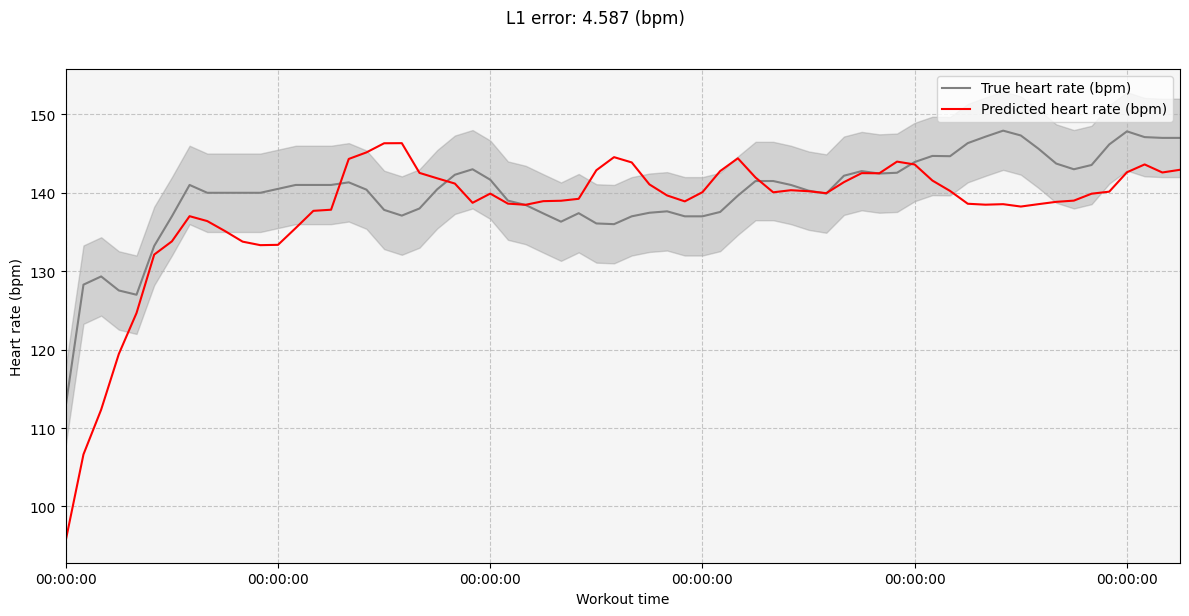

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_single_workout_with_error_bands(model, workout, error_std_dev=5):
    """
    Plots the true heart rate with error bands and the predicted heart rate for a single workout.
    """
    time_in_seconds = workout["time"]
    time_in_datetime = pd.to_datetime(time_in_seconds, unit="s") - pd.to_datetime(time_in_seconds[0], unit="s")
    time_in_datetime = time_in_datetime + pd.Timestamp('1970-01-01')

    true_heart_rate = workout["heart_rate"]
    predictions = model.forecast_single_workout(workout)
    predicted_heart_rate = predictions["heart_rate"]

    # Ensure the lengths match
    if len(true_heart_rate) != len(predicted_heart_rate):
        min_len = min(len(true_heart_rate), len(predicted_heart_rate))
        true_heart_rate = true_heart_rate[:min_len]
        predicted_heart_rate = predicted_heart_rate[:min_len]
        time_in_datetime = time_in_datetime[:min_len]

    # Error bounds: standard deviation of ± 5 beats per minute
    error_bounds = np.full_like(true_heart_rate, error_std_dev)

    # Calculate L1 error (Mean Absolute Error)
    l1_error = np.mean(np.abs(true_heart_rate - predicted_heart_rate))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'L1 error: {l1_error:.3f} (bpm)', y=1.02)

    # Plot true heart rate with error bands
    ax.plot(time_in_datetime, true_heart_rate, color='gray', label='True heart rate (bpm)')
    ax.fill_between(time_in_datetime, true_heart_rate - error_bounds, true_heart_rate + error_bounds, color='gray', alpha=0.3)
    
    # Plot predicted heart rate
    ax.plot(time_in_datetime, predicted_heart_rate, color='red', label='Predicted heart rate (bpm)')

    # Add labels and title
    ax.set_xlabel('Workout time')
    ax.set_ylabel('Heart rate (bpm)')
    ax.legend()

    # Format the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim([time_in_datetime.min(), time_in_datetime.max()])
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_facecolor('#f5f5f5')

    plt.tight_layout()
    plt.show()

# Plot for the workout from the test dataset
plot_single_workout_with_error_bands(model, test_dataset[10])
